In [ ]:
pip install grinpy

     |████████████████████████████████| 46 kB 2.9 MB/s 
     |████████████████████████████████| 14.2 MB 15.8 MB/s 


In [ ]:
pip install stellargraph

     |████████████████████████████████| 435 kB 8.9 MB/s 
     |████████████████████████████████| 462 kB 63.9 MB/s 


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from random import randrange, shuffle
import numpy as np
from google.colab import drive
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]=""
import ast
import scipy
import grinpy as gp

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tensorflow.python.framework.ops import Tensor
from tqdm.notebook import tqdm
import timeit
from gensim.models import Word2Vec
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

# Generating graphs with degrees equal to chromatic number if possible

In [ ]:
def graph_generator_entropy(n, chromatic_number, entropy_num_of_available_vertices = True):
    adj_matrix = [[0 for i in range(n)] for j in range(n)]
    to_visit = [i for i in range(n)]
    colors = [-1 for i in range(n)]
    flag_no_avaliable_colors = False
    while True:
        if len(to_visit) == 0:
            break
        entropy = [0] * n
        if entropy_num_of_available_vertices:
            for i in range(n):
                entropy[i] = chromatic_number - adj_matrix[i].count(1)
#         else:
#             for i in range(n):
#                 entropy[i] = chromatic_number - adj_matrix[i].count(1) # try to save possible values of color and subtract number of impossible
        vertices = sorted(list(enumerate(entropy)), key=lambda x:x[1])
        vertex = -1
        val = -1
        for i in range(n):
            if vertices[i][0] in to_visit:
                vertex = vertices[i][0]
                val = vertices[i][1]
                break
        if val <= 0:
            vertex_neighbours = [i for i,x in enumerate(adj_matrix[vertex]) if x == 1]
            vertex_neighbours_colors = set([colors[x] for x in vertex_neighbours])
            min_avaliable_color_vertex_without_neighbours = -1
            for i in range(chromatic_number):
                if i not in vertex_neighbours_colors:
                    min_avaliable_color_vertex_without_neighbours = i
                    break
            if min_avaliable_color_vertex_without_neighbours == -1:
                flag_no_avaliable_colors = True
                break
        else:
            pool_of_potential_neighbours = set([i for i in range(n)])
            already_neighbours = set([i for i,x in enumerate(adj_matrix[vertex]) if x == 1])
            same_colored = set()
            if colors[vertex] != -1:
                same_colored = set([i for i,x in enumerate(colors) if x == colors[vertex]])
            pool_of_potential_neighbours -= already_neighbours
            pool_of_potential_neighbours -= same_colored
            pool_of_potential_neighbours -= set([vertex])
            pool_of_potential_neighbours = list(pool_of_potential_neighbours)
            if len(already_neighbours) > 0:
                number_of_vertices_to_generate = randrange(chromatic_number - len(already_neighbours) + 1)
            else:
                number_of_vertices_to_generate = randrange(chromatic_number) + 1
            # check if there are no avaliable colors left
            vertex_neighbours = [i for i,x in enumerate(adj_matrix[vertex]) if x == 1]
            vertex_neighbours_colors = set([colors[x] for x in vertex_neighbours])
            min_avaliable_color_vertex_without_neighbours = -1
            for i in range(chromatic_number):
                if i not in vertex_neighbours_colors:
                    min_avaliable_color_vertex_without_neighbours = i
                    break
            if min_avaliable_color_vertex_without_neighbours == -1:
                flag_no_avaliable_colors = True
                break
            edges_generated = 0
            while edges_generated < number_of_vertices_to_generate and len(pool_of_potential_neighbours) > 0:
                pos = randrange(len(pool_of_potential_neighbours))
                neighbour = pool_of_potential_neighbours[pos]
                del pool_of_potential_neighbours[pos]
                if colors[vertex] == -1 and colors[neighbour] == -1:
                    adj_matrix[neighbour][vertex] = 1
                    adj_matrix[vertex][neighbour] = 1
                    edges_generated += 1
                    colors[vertex] = min_avaliable_color_vertex_without_neighbours
                elif colors[vertex] == -1 and colors[neighbour] != -1:
                    vertex_neighbours = [i for i,x in enumerate(adj_matrix[vertex]) if x == 1]
                    vertex_neighbours_colors = set([colors[x] for x in vertex_neighbours]).union(set([colors[neighbour]]))
                    min_avaliable_color_vertex = -1
                    for i in range(chromatic_number):
                        if i not in vertex_neighbours_colors:
                            min_avaliable_color_vertex = i
                            break
                    if min_avaliable_color_vertex != -1:
                        colors[vertex] = min_avaliable_color_vertex
                        adj_matrix[neighbour][vertex] = 1
                        adj_matrix[vertex][neighbour] = 1
                        edges_generated += 1
                elif colors[vertex] != colors[neighbour]:
                    adj_matrix[neighbour][vertex] = 1
                    adj_matrix[vertex][neighbour] = 1
                    edges_generated += 1
            if colors[vertex] == -1:
                colors[vertex] = min_avaliable_color_vertex_without_neighbours
        to_visit.remove(vertex)
    if flag_no_avaliable_colors:
        return -1,-1,-1
    return adj_matrix, max(colors) + 1, colors

## Data generation test

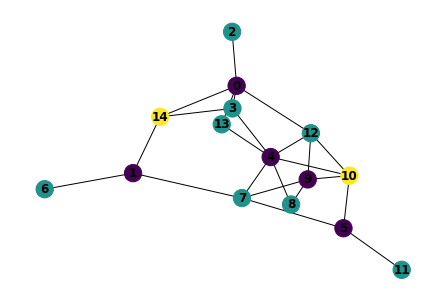

In [ ]:
# test
A, B, color_map = graph_generator_entropy(15, 5)
# print(np.array([np.array(x) for x in A]))
# print(color_map)
edges = set()
for i in range(len(A)):
    for j in range(i, len(A)):
        if A[i][j] == 1:
            edges.add((i, j))
# print(np.array([np.array(x) for x in A]))
# print(edges)
for el in edges:
    if color_map[el[0]] == color_map[el[1]]:
        print('ERROR!')

if A != -1:
    G = nx.Graph()
    G = nx.from_numpy_matrix(np.array([np.array(x) for x in A]))
    nx.draw(G, with_labels=True, font_weight='bold', node_color=color_map)

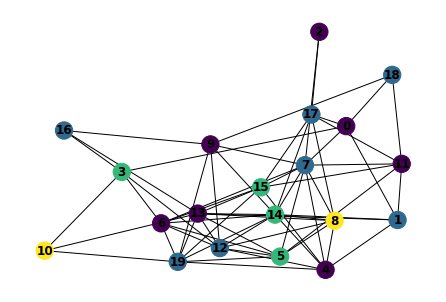

In [ ]:
# test
A, B, color_map = graph_generator_entropy(20, 7)
# print(np.array([np.array(x) for x in A]))
# print(color_map)
edges = set()
for i in range(len(A)):
    for j in range(i, len(A)):
        if A[i][j] == 1:
            edges.add((i, j))
# print(np.array([np.array(x) for x in A]))
# print(edges)
for el in edges:
    if color_map[el[0]] == color_map[el[1]]:
        print('ERROR!')

if A != -1:
    G = nx.Graph()
    G = nx.from_numpy_matrix(np.array([np.array(x) for x in A]))
    nx.draw(G, with_labels=True, font_weight='bold', node_color=color_map)

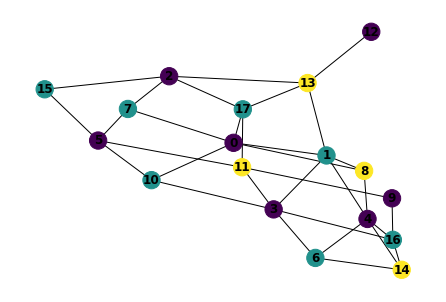

In [ ]:
# test
A, B, color_map = graph_generator_entropy(18, 4)
# print(np.array([np.array(x) for x in A]))
# print(color_map)
edges = set()
for i in range(len(A)):
    for j in range(i, len(A)):
        if A[i][j] == 1:
            edges.add((i, j))
# print(np.array([np.array(x) for x in A]))
# print(edges)
for el in edges:
    if color_map[el[0]] == color_map[el[1]]:
        print('ERROR!')

if A != -1:
    G = nx.Graph()
    G = nx.from_numpy_matrix(np.array([np.array(x) for x in A]))
    nx.draw(G, with_labels=True, font_weight='bold', node_color=color_map)

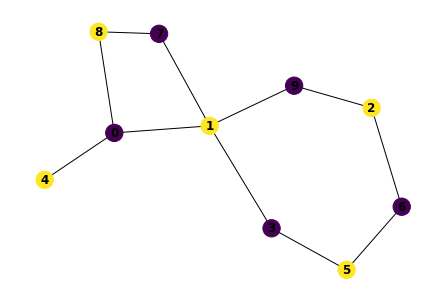

In [ ]:
# test
A, B, color_map = graph_generator_entropy(10, 2)
# print(np.array([np.array(x) for x in A]))
# print(color_map)
edges = set()
for i in range(len(A)):
    for j in range(i, len(A)):
        if A[i][j] == 1:
            edges.add((i, j))
# print(np.array([np.array(x) for x in A]))
# print(edges)
for el in edges:
    if color_map[el[0]] == color_map[el[1]]:
        print('ERROR!')

if A != -1:
    G = nx.Graph()
    G = nx.from_numpy_matrix(np.array([np.array(x) for x in A]))
    nx.draw(G, with_labels=True, font_weight='bold', node_color=color_map)

## Generating data

In [ ]:
# https://github.com/somacdivad/grinpy/blob/master/grinpy/invariants/chromatic.py
def coloring_of_graph(G):
    color_map = gp.min_proper_coloring(G)
    color_m = [0] * 31
    color = 0
    for i in color_map.items():
        if i[1]:
            for el in i[1]:
                color_m[el] = color
            color += 1
    return color_m

In [ ]:
# GENERATING TRAIN DATA

for i in range(2, 6):
    graphs_generated = 0
    root_path = '/content/drive/MyDrive/ildazavr/train_dataset_exact_coloring_/batch' + str(i - 1) + '/'
    if not os.path.exists(root_path):
        os.makedirs(root_path)
    while graphs_generated < i * 200:
        adj_matrix, trash_1, trash_2 = graph_generator_entropy(31, i)
        if adj_matrix == -1:
            continue
        G = nx.from_numpy_matrix(np.matrix(adj_matrix))
        if not nx.is_connected(G):
            continue
        coloring = coloring_of_graph(G)
        chromatic_number = max(coloring) + 1
        with open(root_path + 'file' + str(graphs_generated) + '.txt', 'w') as fp:
            fp.write(str(adj_matrix))
            fp.write('\n' + str(chromatic_number))
            fp.write('\n' + str(coloring))
        graphs_generated += 1
        if graphs_generated % 200 == 0:
            print(graphs_generated)
    print("Cycle", i, "done!")

200
400
Cycle 2 done!
200
400
600
Cycle 3 done!
200
400
600
800
Cycle 4 done!


In [ ]:
# GENERATING TEST DATA

for i in range(2, 6):
    graphs_generated = 0
    root_path = '/content/drive/MyDrive/ildazavr/test_dataset_exact_coloring_/batch' + str(i - 1) + '/'
    if not os.path.exists(root_path):
        os.makedirs(root_path)
    val = i * 20
    if i == 5:
        val = 40
    while graphs_generated < val:
        adj_matrix, trash_1, trash_2 = graph_generator_entropy(31, i)
        if adj_matrix == -1:
            continue
        G = nx.from_numpy_matrix(np.matrix(adj_matrix))
        if not nx.is_connected(G):
            continue
        coloring = coloring_of_graph(G)
        chromatic_number = max(coloring) + 1
        with open(root_path + 'file' + str(graphs_generated) + '.txt', 'w') as fp:
            fp.write(str(adj_matrix))
            fp.write('\n' + str(chromatic_number))
            fp.write('\n' + str(coloring))
        graphs_generated += 1
        if graphs_generated % 200 == 0:
            print(graphs_generated)
    print("Cycle", i, "done!")

Cycle 2 done!
Cycle 3 done!
Cycle 4 done!
Cycle 5 done!


## Validating generated data and shuffling order of nodes

In [ ]:
# DATA VALIDATION

directory = '/content/drive/MyDrive/ildazavr/train_dataset_exact_coloring_'
values_in_adj_mat = set([0, 1])
for subdirectory in os.listdir(directory):
    for file in os.listdir(os.path.join(directory, subdirectory)):
        file_path = os.path.join(directory, subdirectory, file)
        with open(file_path) as f:
            contents = f.readlines()
        for el in ast.literal_eval(contents[0]): 
            if not set(el).issubset(values_in_adj_mat):
                print('Error in adj matrix:', file_path)
        if int(contents[1]) < 0:
            print('Error in number of colors:', file_path)
        coloring = greedyColoring(ast.literal_eval(contents[0]))
        if int(contents[1]) > max(coloring) + 1:
            print(file_path)
        if -1 in ast.literal_eval(contents[2]):
            print('Error in coloring:', file_path)

[[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

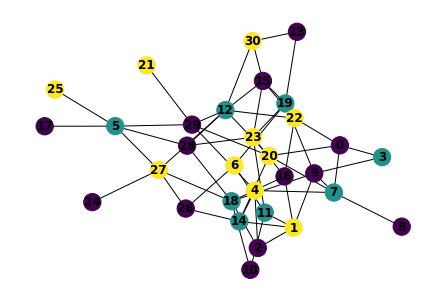

In [ ]:
# Visualize graph

path_to_file = '/content/drive/MyDrive/ildazavr/train_dataset_exact_coloring_/batch4/file14.txt'
with open(path_to_file) as f:
    contents = f.readlines()
print(contents[0])
print(contents[1])
print(contents[2])
f.close()

G = nx.from_numpy_matrix(np.array([np.array(x) for x in ast.literal_eval(contents[0])]))
color_map = ast.literal_eval(contents[2])
nx.draw(G, with_labels=True, font_weight='bold', node_color=color_map)

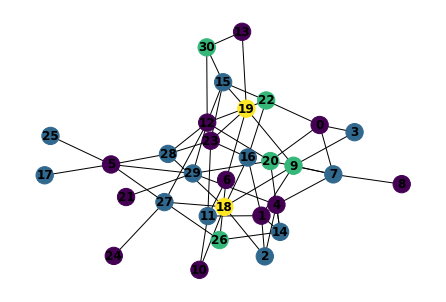

In [ ]:
# compare with greedy

coloring = greedyColoring(ast.literal_eval(contents[0]))
nx.draw(G, with_labels=True, font_weight='bold', node_color=coloring)

In [ ]:
# DATA SHUFFLE

directory = '/content/drive/MyDrive/ildazavr/test_dataset_exact_coloring_'
keys = list(np.arange(0, 31))
values = list(np.arange(0, 31))
for subdirectory in os.listdir(directory):
    for file in os.listdir(os.path.join(directory, subdirectory)):
        file_path = os.path.join(directory, subdirectory, file)
        with open(file_path, "r") as f:
            contents = f.readlines()
            G = nx.from_numpy_matrix(np.matrix(ast.literal_eval(contents[0])))
            shuffle(values)
            new_nodes = dict(zip(keys, values))
            matrix = np.zeros((31, 31))
            edges = set(G.edges())
            for el in edges:
                matrix[new_nodes[el[0]]][new_nodes[el[1]]] = 1
                matrix[new_nodes[el[1]]][new_nodes[el[0]]] = 1
            new_coloring = [0]*31
            coloring = ast.literal_eval(contents[2])
            new_nodes_ = dict(zip(values, keys))
            for i in range(len(values)):
                new_coloring[i] = coloring[new_nodes_[i]]
        with open(file_path, "w") as f:
            f.write(str(matrix.astype(int).tolist()))
            f.write('\n' + str(contents[1]))
            f.write(str(new_coloring))

# Graph generating with baskets

In [ ]:
# implement if enough time left

def graph_generator_baskets(chromatic_number, basket_size_low_bound, basket_size_high_bound, density): # chromatic number = number of baskets
    pass

# Graph greedy algorithm

In [ ]:
# Assigns colors (starting from 0) to all
# vertices and prints the assignment of colors
def greedyColoring(adj_mat):
    V = len(adj_mat)
    coloring = [-1] * V
    coloring[0] = 0
    not_available = set()
    adj = [[] for i in range(V)]
    for i in range(V):
        for j in range(V):
            if adj_mat[i][j] == 1 and i != j:
                adj[i].append(j)
    for u in range(1, V):
        for i in adj[u]:
              not_available.add(coloring[i])
        min_color = 0
        while min_color < V:
            if min_color not in not_available:
                break
            min_color += 1
        coloring[u] = min_color
        not_available.clear()
    return coloring

## Testing

[0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 1, 1, 2, 0, 3, 1, 1, 2]
Total colors: 3
Total colors greedy: 4


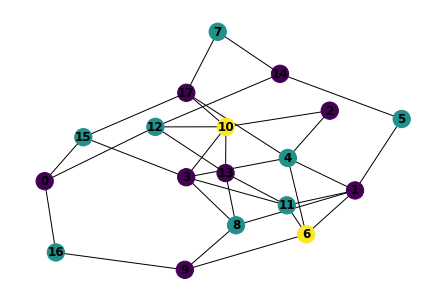

In [ ]:
A, B, color_map = graph_generator_entropy(18, 4)

edges = set()
for i in range(len(A)):
    for j in range(i, len(A)):
        if A[i][j] == 1:
            edges.add((i, j))

for el in edges:
    if color_map[el[0]] == color_map[el[1]]:
        print('ERROR!')

if A != -1:
    G = nx.Graph()
    G = nx.from_numpy_matrix(np.array([np.array(x) for x in A]))
    nx.draw(G, with_labels=True, font_weight='bold', node_color=color_map)

res = greedyColoring(A)
print(res)
print('Total colors:', B)
print('Total colors greedy:', max(res) + 1)

[0, 0, 1, 0, 1, 0, 1, 1, 2, 3, 2, 2, 0, 3, 2, 0, 3, 0, 1, 2]
Total colors: 4
Total colors greedy: 4


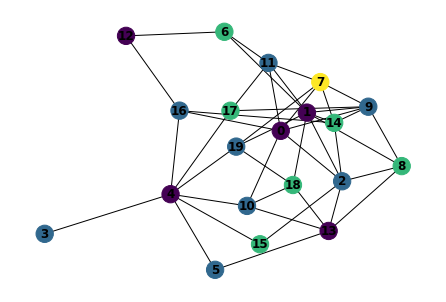

In [ ]:
A, B, color_map = graph_generator_entropy(20, 6)

edges = set()
for i in range(len(A)):
    for j in range(i, len(A)):
        if A[i][j] == 1:
            edges.add((i, j))

for el in edges:
    if color_map[el[0]] == color_map[el[1]]:
        print('ERROR!')

if A != -1:
    G = nx.Graph()
    G = nx.from_numpy_matrix(np.array([np.array(x) for x in A]))
    nx.draw(G, with_labels=True, font_weight='bold', node_color=color_map)

res = greedyColoring(A)
print(res)
print('Total colors:', B)
print('Total colors greedy:', max(res) + 1)

[0, 1, 2, 1, 0, 0, 1, 0, 1, 2, 2, 2, 2, 0, 3, 1, 3, 3, 4, 2]
Total colors: 3
Total colors greedy: 5


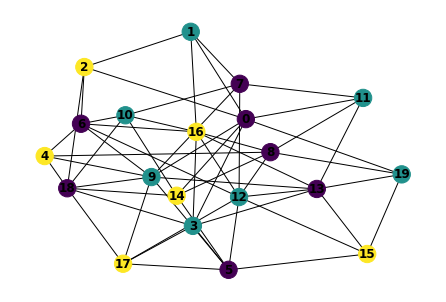

In [ ]:
A, B, color_map = graph_generator_entropy(20, 6)

edges = set()
for i in range(len(A)):
    for j in range(i, len(A)):
        if A[i][j] == 1:
            edges.add((i, j))

for el in edges:
    if color_map[el[0]] == color_map[el[1]]:
        print('ERROR!')

if A != -1:
    G = nx.Graph()
    G = nx.from_numpy_matrix(np.array([np.array(x) for x in A]))
    nx.draw(G, with_labels=True, font_weight='bold', node_color=color_map)

res = greedyColoring(A)
print(res)
print('Total colors:', B)
print('Total colors greedy:', max(res) + 1)

[0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 1, 2, 1, 2, 2, 3, 0, 3, 3, 1, 0, 2, 1, 0, 2, 1, 3]
Total colors: 3
Total colors greedy: 4


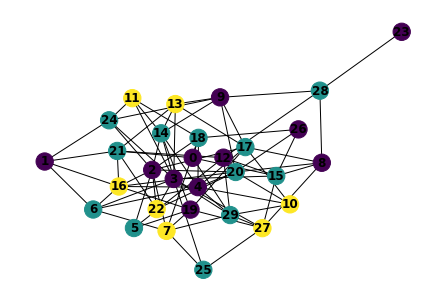

In [ ]:
A, B, color_map = graph_generator_entropy(30, 7)

edges = set()
for i in range(len(A)):
    for j in range(i, len(A)):
        if A[i][j] == 1:
            edges.add((i, j))

for el in edges:
    if color_map[el[0]] == color_map[el[1]]:
        print('ERROR!')

if A != -1:
    G = nx.Graph()
    G = nx.from_numpy_matrix(np.array([np.array(x) for x in A]))
    nx.draw(G, with_labels=True, font_weight='bold', node_color=color_map)

res = greedyColoring(A)
print(res)
print('Total colors:', B)
print('Total colors greedy:', max(res) + 1)

# Graph greedy alogorithm with ML

## Dataset


---



In [ ]:
# Loader functions

def default_loader_(path):
    with open(path, 'rb') as f:
        contents = f.readlines()
        matrix = ast.literal_eval(contents[0].decode("utf-8"))
        return np.array([np.array(x) for x in matrix]), int(contents[1].decode("utf-8")), np.array(ast.literal_eval(contents[2].decode("utf-8")), dtype = 'int')

In [ ]:
def get_file_count(path):
    fileCount = 0
    try:
        for base, dirs, files in os.walk(path):
            for f in files:
                fileCount += 1
    except:
        return 0
    return fileCount

In [ ]:
save_path = "/content/drive/MyDrive/ildazavr/states"
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset

class GraphDataset(datasets.VisionDataset):
    def __init__(self, root, partition_count, graph_loader=default_loader_, 
                             transform=transforms.ToTensor(),):
        """
        Inputs:
                root            : Directory with our graphs.
                transform : Optional transform to be applied on a sample
        """
        super().__init__(root, transform=transform)
        self.part_count = partition_count
        self.graph_loader = graph_loader
        self.total_count = 0
        self.part_sizes = []
        self.part_start = 1
        self.part_size = get_file_count(root)
        for j in range(self.part_start, self.part_start + self.part_count):
            part_name = "batch{}".format(j)
            cur_sz = get_file_count(os.path.join(self.root, part_name))
            self.part_sizes.append(cur_sz)
            self.total_count += cur_sz
        

    def _graph_load(self, path):
        g, target_count, target = self.graph_loader(path)
        x = self.transform(g) if (self.transform) else g
        return x, target_count, target

    def __getitem__(self, i): # 1500
        part_index = self.part_start
        thresh = 0
        for part_el in self.part_sizes:
            thresh += part_el
            if i < thresh:
                break
            else:
                part_index += 1
        part_name = "batch{}".format(part_index)
        part_path = os.path.join(self.root, part_name)
        fname = "file{}.txt".format(i % self.part_sizes[part_index - 1])
        g, target_count, target = self._graph_load(os.path.join(part_path, fname))
        return {'graph': g,
                        'target': target_count,
                        'coloring': target
                        } 

    def __len__(self):
        return self.total_count

## Autoencoder


---

In [ ]:
# Basic AutoEncoder
# The "smart" part to this AE comes from the loss being complicated
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(33, 24),
            nn.LeakyReLU(),
      nn.Linear(24, 18),
            nn.LeakyReLU(),
            nn.Linear(18, 14),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(14, 18),
            nn.LeakyReLU(),
      nn.Linear(18, 24),
            nn.LeakyReLU(),
            nn.Linear(24, 33),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Simple Model

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self, internal_size=20, lstm_layers=4, lstm_size=20, lstm_bias=False, lstm_reg=0, batch_first=True, device=torch.device("cuda:0"), correction_func = torch.nn.Sigmoid()):
        super().__init__()
        self.internal_size = internal_size
        self.correction_func = correction_func
        mid = (14 + internal_size) // 2
        if mid > 14:
            self.pre_process = nn.Sequential(
                nn.Linear(14, mid),
                # nn.BatchNorm1d(mid),
                nn.LeakyReLU(),
                nn.Linear(mid, internal_size),
                # nn.BatchNorm1d(internal_size),
                nn.LeakyReLU(),
            )
        else:
            self.pre_process = nn.Sequential(
                nn.Linear(14, internal_size),
                # nn.BatchNorm1d(internal_size),
                nn.LeakyReLU(),
            )
        self.lstm_layers = lstm_layers
        self.mem = nn.Identity()
        
        post_process_size = internal_size
        if lstm_layers > 0:
            post_process_size = lstm_size
            self.mem = nn.LSTM(internal_size, lstm_size, lstm_layers, bias=lstm_bias, batch_first=batch_first, dropout=lstm_reg,)
        self.mem_state = torch.zeros((1, post_process_size), dtype=torch.float, device=device)
        compound_size = post_process_size + internal_size
        self.post_process = nn.Sequential(
            nn.Linear(compound_size, int(0.75 * compound_size)),
            nn.BatchNorm1d(int(0.75 * compound_size)),
            nn.LeakyReLU(),
            nn.Linear(int(0.75 * compound_size), post_process_size),
            nn.BatchNorm1d(post_process_size),
            nn.LeakyReLU(),
            nn.Linear(post_process_size, internal_size),
            nn.BatchNorm1d(internal_size),
            nn.LeakyReLU(),
            nn.Linear(internal_size,(internal_size * 2) // 3),
            nn.BatchNorm1d((internal_size * 2) // 3),
            nn.LeakyReLU(),
            nn.Linear((internal_size * 2) // 3, internal_size // 3),
            nn.LeakyReLU(),
            nn.Linear(internal_size // 3, 2),
        )

    def forward(self, x):
        # first is batch index, then rows of encoded vectors
        v_indecies = x[:, 0] # 31 x [33+8]
        pre_proc = self.pre_process(x[:, 33:])
        proc = torch.cat((F.pad(self.mem_state, (0, 0, 0, pre_proc.shape[0] - self.mem_state.shape[0]), "constant", 0), pre_proc), dim=1)
        post_proc = self.post_process(proc)
        post_proc[:, 1] = self.correction_func(post_proc[:, 1])
        return torch.cat((v_indecies.reshape(-1,1), post_proc), dim=1) # vertex float1 float2
    
    def fill_memory(self, x):
        pre_proc = self.pre_process(x[:, 33:])
        if self.lstm_layers:
            self.mem_state, (hn, cn) = self.mem(pre_proc)
        else:
            self.mem_state = self.mem(pre_proc)
        return self.mem_state

In [ ]:
def prepare_encode(ae, mat, vertex_index, vertex_color=-1, device=torch.device("cuda:0")):
    return torch.tensor([vertex_index, vertex_color] + mat[vertex_index, :].tolist(), dtype=torch.float).to(device)
    # return [vertex_index, vertex_color] + mat[vertex_index, :].tolist()

def ae_encode(ae, prepped, stack_dim=1):
    enc = ae.encoder(prepped)
    return torch.cat((prepped[ :, :], enc), dim=stack_dim)

## Greedy for autoencoder

In [ ]:
def logGreedyColoring(model, ae, adj_matrix, data, adj, colors, vc_count, confidence_in_colors):
    output = model(data).to(torch.device("cuda:0")) # 1st float is for order, 2nd float is for confidence
    sorted_output = sorted(output, key=lambda x:x[1]) # sort by order float
    left_to_color = len(sorted_output) - vc_count
    colored_vertices = []
    max_color = 0
    max_float = sorted_output[vc_count - 1][1]
    for el in sorted_output[:vc_count]:
        vertex = el[0]
        blocked_colors = set()
        for neigh in adj[int(vertex)]:
            blocked_colors.add(colors[neigh])
        for i in range(999):
            if i not in blocked_colors:
                colors[int(vertex)] = i
                colored_vertices.append([el[0], el[2], i]) # vertex, confidence float, color
                if i > max_color:
                    max_color = i
                break
    for cur in range(len(colored_vertices)): # iter all colored vertices
        new_conf_vec = [(1 - colored_vertices[cur][1]) / max_color] * (max_color + 1)
        new_conf_vec[colored_vertices[cur][2]] = colored_vertices[cur][1]
        confidence_in_colors.append([new_conf_vec, colored_vertices[cur][0]])
    mask = torch.tensor(list(list(zip(*sorted(list(zip(sorted_output[vc_count:], np.zeros(len(sorted_output) - vc_count))) + list(zip(sorted_output[:vc_count], np.ones(vc_count))), key=lambda x: x[0][0])))[1])).eq(1)
    v_colored = ae_encode(ae, torch.stack(list(map(lambda vert: prepare_encode(ae, adj_matrix, int(vert[0]), colors[int(vert[0])]), data[mask]))).to("cuda:0"))
    model.fill_memory(v_colored)
    if left_to_color > 0:
        v_to_color = list(map(lambda vert: prepare_encode(ae, adj_matrix, int(vert[0])), data[~mask]))
        return logGreedyColoring(model, ae, adj_matrix, ae_encode(ae, torch.stack(v_to_color).to("cuda:0")), adj, colors, min(2 * vc_count, left_to_color), confidence_in_colors)
    return colors, confidence_in_colors

def greedyColoringLog(model, ae, data, adj_matrix):
    V = len(data)
    colors = [-1] * V                         # colors of vertices
    adj = [[] for i in range(V)]    # neighbours
    for i in range(V):
        for j in range(V):
            if adj_matrix[i][j] == 1 and i != j:
                adj[i].append(j)
    return logGreedyColoring(model, ae, adj_matrix, data, adj, colors, 1, [])

def greedyColoringSimple(model, data, adj_matrix):
    V = len(data)
    colors = [-1] * V                         # colors of vertices
    adj = [[] for i in range(V)]    # neighbours
    for i in range(V):
        for j in range(V):
            if adj_matrix[i][j] == 1 and i != j:
                adj[i].append(j)
    output = enumerate(model(data).to(torch.device("cuda:0")))
    new_out = sorted(output, key=lambda x:x[1]) # sort by float
    for el in new_out:
        vertex = el[0]
        blocked_colors = set()
        for neigh in adj[vertex]:
            blocked_colors.add(colors[neigh])
        for i in range(999):
            if i not in blocked_colors:
                colors[el[0]] = i
                break
    return colors

## Trainer function for autoencoder

In [ ]:
# if we get interrupted - load from a safepoint or whatever
load_batch = 0

In [ ]:
# Trainer function
def train_one_epoch(model, ae, epoch, train_dataloader, reg_weight=0.1, alg_weight=0.25, cc_weight=1, ae_weight=0.5, criterion=nn.CrossEntropyLoss(), cc_criterion=None, ae_criterion=None, optimizer=torch.optim.Adam, iter_num = 0, device="cuda:0", save_path=save_path, snapshot_freq=50):
    model.train()
    # forward, calculate loss, backward, optimizer step, etc...
    progress_bar = tqdm(train_dataloader, total=len(train_dataloader))
    i = 0
    for batch in progress_bar:
        if (i < load_batch):
            i += 1
            continue  
        adj_mat, target, coloring = batch['graph'], batch['target'].to(device), batch['coloring'].to(device)
        # prepped, encoded = torch.tensor(list(map(lambda vert: prepare_encode(ae, adj_mat[0][0], vert), np.arange(len(adj_mat))))).to(device)
        
        crit_1 = []
        crit_2 = []
        crit_3 = []
        available_batch_size = len(adj_mat)
        for k in range(available_batch_size):

            model.mem_state = torch.zeros((1, model.internal_size), dtype=torch.float, device=device)
            prep = []
            for elem in np.arange(len(adj_mat[k][0])):
                prep.append(prepare_encode(ae, adj_mat[k][0], elem))
            prepped = torch.stack(prep).to(device)

            data = ae_encode(ae, prepped)
            model.fill_memory(data)

            colors, conf_in_colors = greedyColoringLog(model, ae, data, adj_mat[k][0])
            cc = np.max(colors) + 1
            for pos in range(len(conf_in_colors)):
                if len(conf_in_colors[pos][0]) < cc:
                    conf_in_colors[pos][0] += torch.tensor([0] * (cc - len(conf_in_colors[pos][0]))).to(device)

            conf_in_colors.sort(key=lambda x:x[1])
            list_with_stacked_tensors = [torch.stack((pair[0])) for pair in conf_in_colors] # list of tensors
            conf_in_coloring = torch.stack((list_with_stacked_tensors)).to(device) # tensor
            cur_coloring = coloring[k].type(torch.LongTensor).to(device)
            crit_1.append(criterion(conf_in_coloring, cur_coloring))
            crit_2.append(cc_criterion(cc, target[k].detach().cpu().numpy()))
            # crit_2.append(cc_criterion(torch.tensor(cc, dtype=torch.float).to(device), target[k].type(torch.float).to(device)))
            crit_3.append(ae_criterion(ae.decoder(data[:, 33:]), prepped))
        value_1 = torch.mean(torch.stack(crit_1))
        # value_2 = torch.mean(torch.stack(crit_2))
        value_2 = np.mean(crit_2)
        value_3 = torch.mean(torch.stack(crit_3))
        alg_loss = alg_weight * value_1 + cc_weight * value_2
        total_loss = alg_loss + ae_weight * value_3
    

        # Backprop
        optimizer.zero_grad()
        alg_loss.backward(retain_graph=True)
        total_loss.backward(retain_graph=True)
        optimizer.step()
        progress_bar.set_description("Current Loss = {:.4f} | AE loss = {:.4f} | Alg CC = {:.4f} | Alg CE = {:.4f}".format(total_loss.item(), value_3.item(), value_2.item(), value_1.item()))
        if (i % snapshot_freq == 0) and not (i == 0 and epoch == 0):
            state_dict = model.state_dict()
            ae_state = ae.state_dict()
            opt_state = optimizer.state_dict()
            torch.save(state_dict, os.path.join(save_path, "model_state_i{0}e{1}p{2}.tar".format(iter_num, epoch, i)))
            torch.save(ae_state, os.path.join(save_path, "ae_state_i{0}e{1}p{2}.tar".format(iter_num, epoch, i)))
            torch.save(opt_state, os.path.join(save_path, "optimizer_state_i{0}e{1}p{2}.tar".format(iter_num, epoch, i)))
        i += 1
    return optimizer.state_dict() 

## Greedy test for autoencoder

In [ ]:
def logGreedyColoring_noConf(model, ae, adj_matrix, data, adj, colors, vc_count):
    output = model(data).to(torch.device("cuda:0")) # 1st float is for order, 2nd float is for confidence
    sorted_output = sorted(output, key=lambda x:x[1]) # sort by order float
    left_to_color = len(sorted_output) - vc_count
    for el in sorted_output[:vc_count]:
        vertex = el[0]
        blocked_colors = set()
        for neigh in adj[int(vertex)]:
            blocked_colors.add(colors[neigh])
        for i in range(999):
            if i not in blocked_colors:
                colors[int(vertex)] = i
                break
    mask = torch.tensor(list(list(zip(*sorted(list(zip(sorted_output[vc_count:], np.zeros(len(sorted_output) - vc_count))) + list(zip(sorted_output[:vc_count], np.ones(vc_count))), key=lambda x: x[0][0])))[1])).eq(1)
    v_colored = ae_encode(ae, torch.stack(list(map(lambda vert: prepare_encode(ae, adj_matrix, int(vert[0]), colors[int(vert[0])]), data[mask]))).to("cuda:0"))
    model.fill_memory(v_colored)
    if left_to_color > 0:
        v_to_color = list(map(lambda vert: prepare_encode(ae, adj_matrix, int(vert[0])), data[~mask]))
        return logGreedyColoring_noConf(model, ae, adj_matrix, ae_encode(ae, torch.stack(v_to_color).to("cuda:0")), adj, colors, min(2 * vc_count, left_to_color))
    return colors

def greedyColoringLog_noConf(model, ae, data, adj_matrix):
    V = len(data)
    colors = [-1] * V                         # colors of vertices
    adj = [[] for i in range(V)]    # neighbours
    for i in range(V):
        for j in range(V):
            if adj_matrix[i][j] == 1 and i != j:
                adj[i].append(j)
    return logGreedyColoring_noConf(model, ae, adj_matrix, data, adj, colors, 1)

def greedyColoringSimple(model, data, adj_matrix):
    V = len(data)
    colors = [-1] * V                         # colors of vertices
    adj = [[] for i in range(V)]    # neighbours
    for i in range(V):
        for j in range(V):
            if adj_matrix[i][j] == 1 and i != j:
                adj[i].append(j)
    output = enumerate(model(data).to(torch.device("cuda:0")))
    new_out = sorted(output, key=lambda x:x[1]) # sort by float
    for el in new_out:
        vertex = el[0]
        blocked_colors = set()
        for neigh in adj[vertex]:
            blocked_colors.add(colors[neigh])
        for i in range(999):
            if i not in blocked_colors:
                colors[el[0]] = i
                break
    return colors

## Testing autoencoder

In [ ]:
# testing model

def test_model(model, ae, epoch, test_loader, device="cuda:0"):


    # model = SimpleModel(internal_size=20, lstm_layers=20, lstm_size=20,).to("cuda")
    # model.load_state_dict(torch.load("/content/drive/MyDrive/ildazavr/states/model_state_e4p50.tar", map_location=torch.device('cuda:0')))
    model.eval()

    # ae = AE().to("cuda")
    # ae.load_state_dict(torch.load("/content/drive/MyDrive/ildazavr/states/ae_state_e4p50.tar", map_location=torch.device('cuda:0')))
    ae.eval()

    greedy_random = []
    greedy_ml = []
    best_values = []
    total_time_ml = []
    total_time_greedy = []
    with torch.no_grad():
        progress_bar = tqdm(test_loader, total=len(test_loader))
        for batch in progress_bar:
            adj_mat, target, coloring = batch['graph'], batch['target'], batch['coloring']
            available_batch_size = len(adj_mat)
            for k in range(available_batch_size):
              model.mem_state = torch.zeros((1, model.internal_size), dtype=torch.float).to('cuda:0')
              prep = []
              for elem in np.arange(len(adj_mat[k][0])):
                  prep.append(prepare_encode(ae, adj_mat[k][0], elem))
              prepped = torch.stack(prep)

              starttime_ml = timeit.default_timer()
              data = ae_encode(ae, prepped)
              colors = greedyColoringLog_noConf(model, ae, data, adj_mat[k, 0])
              endtime_ml = timeit.default_timer() - starttime_ml
    
              starttime_greedy = timeit.default_timer()
              greedy_random.append(max(greedyColoring(adj_mat[k, 0].numpy())) + 1)
              endtime_greedy = timeit.default_timer() - starttime_greedy
              total_time_ml.append(endtime_ml)
              total_time_greedy.append(endtime_greedy)
              greedy_ml.append(max(colors) + 1)
              best_values.append(int(target[k]))
    print('Greedy value:', np.sum(greedy_random), 'Greedy time:', np.sum(total_time_greedy), 'ML value:', np.sum(greedy_ml), 'ML time:', np.sum(total_time_ml), 'Correct value:', np.sum(best_values))

## Testing hyperparameters

In [ ]:
# Testing hyperparameters

coloring_weight = [0.1, 0.25, 1]
sizes = [10 * i for i in range(1, 4)]
layers = [10 * i for i in range(1, 4)]
learning_rates = [0.005, 0.001, 0.0005, 0.0001]
results = []
iter_num = 0

for cw in coloring_weight:
    for lr in learning_rates:
        for l in layers:
            for s in sizes:
                data = GraphDataset('/content/drive/MyDrive/ildazavr/train_dataset_exact_coloring_/', 4)
                batch_size_ = 8
                start_epoch = 0
                start_iter = 0
                train_loader = torch.utils.data.DataLoader(data, batch_size = batch_size_, shuffle=True, num_workers=0)

                model = SimpleModel(internal_size=s, lstm_layers=l, lstm_size=s,).to('cuda:0')
                ae = AE().to('cuda:0')
                # optimizer = torch.optim.RMSprop(list(model.parameters()) + list(ae.parameters()), lr=2e-3, alpha=0.99, eps=1e-8, weight_decay=1e-4, momentum=1e-3)
                optimizer = torch.optim.RMSprop([
                                {'params': model.parameters()},
                                {'params': ae.parameters(), 'lr': 2e-3}
                            ], lr=lr, alpha=0.99, eps=1e-8, weight_decay=1e-4, momentum=1e-3)
                torch.autograd.set_detect_anomaly(True)

                # def diff_in_colors(a, b):
                #     return np.abs(a - b) * 10

                data_test = GraphDataset('/content/drive/MyDrive/ildazavr/test_dataset_exact_coloring_/', 4)
                test_loader = torch.utils.data.DataLoader(data_test, batch_size = batch_size_, num_workers=0)

                #############

                if start_epoch != 0 or start_iter != 0:
                    model.load_state_dict(torch.load(os.path.join(save_path,"model_state_e{0}p{1}.tar".format(start_epoch, start_iter))))
                    ae.load_state_dict(torch.load(os.path.join(save_path,"ae_state_e{0}p{1}.tar".format(start_epoch, start_iter))))
                    optimizer.load_state_dict(torch.load(os.path.join(save_path,"optimizer_state_e{0}p{1}.tar".format(start_epoch, start_iter))))

                #############

                epochs_results = []
                for i in range(start_epoch, 10):
                    train_one_epoch(model, ae, i, train_loader, criterion = nn.CrossEntropyLoss(), cc_criterion = nn.MSELoss(), ae_criterion = nn.MSELoss(), optimizer = optimizer, iter_num=iter_num, alg_weight = cw)
                    print('Epoch', i, 'done!')
                    state_dict = model.state_dict()
                    torch.save(state_dict, os.path.join(save_path, "model_state_{}_{}.tar".format(iter_num, i)))
                    epochs_results.append(test_model(model, ae, i, test_loader))
                    print('Epoch', i, 'test done!')
                torch.save(model.state_dict(), os.path.join(save_path, "model_test_{}.tar".format(iter_num)))
                torch.save(ae.state_dict(), os.path.join(save_path, "ae_test_{}.tar".format(iter_num)))
                results.append([cw, lr, l, s, epochs_results])
                iter_num += 1

  0%|          | 0/234 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## Training model on autoencoder with random generator

In [ ]:
# training model

data = GraphDataset("/content/drive/MyDrive/ildazavr/train_random_dataset_exact_coloring/", 1)
batch_size_ = 8
start_epoch = 0
start_iter = 0
train_loader = torch.utils.data.DataLoader(data, batch_size = batch_size_, shuffle=True, num_workers=0)

model = SimpleModel(internal_size=40, lstm_layers=30, lstm_size=40,).to('cuda:0')
ae = AE().to('cuda:0')
# optimizer = torch.optim.RMSprop(list(model.parameters()) + list(ae.parameters()), lr=2e-3, alpha=0.99, eps=1e-8, weight_decay=1e-4, momentum=1e-3)
optimizer = torch.optim.RMSprop([
                {'params': model.parameters()},
                {'params': ae.parameters(), 'lr': 2e-3}
            ], lr=0.01, alpha=0.99, eps=1e-8, weight_decay=1e-4, momentum=1e-3)
torch.autograd.set_detect_anomaly(True)

if start_epoch != 0 or start_iter != 0:
  print('Loading model_state_{}.tar'.format(start_epoch - 1))
  model.load_state_dict(torch.load(os.path.join(save_path,"model_state_{}.tar".format(start_epoch - 1))))
  ae.load_state_dict(torch.load(os.path.join(save_path,"ae_test_{}.tar".format(start_epoch - 1))))
  optimizer.load_state_dict(torch.load(os.path.join(save_path,"optimizer_test_{}.tar".format(start_epoch - 1))))
def diff_in_colors(a, b):
    return np.abs(a - b) * 10

data_test = GraphDataset("/content/drive/MyDrive/ildazavr/test_random_dataset_exact_coloring/", 1)
test_loader = torch.utils.data.DataLoader(data_test, batch_size = batch_size_, num_workers=0)

for i in range(start_epoch, 15):
    opt_state = train_one_epoch(model, ae, i, train_loader, criterion = nn.CrossEntropyLoss(), cc_criterion = diff_in_colors, ae_criterion = nn.L1Loss(), optimizer = optimizer, ae_weight=1)
    print('Epoch', i, 'done!')
    state_dict = model.state_dict()
    torch.save(state_dict, os.path.join(save_path, "model_state_{}.tar".format(i)))
    torch.save(ae.state_dict(), os.path.join(save_path, "ae_test_{}.tar".format(i)))
    torch.save(opt_state, os.path.join(save_path, "optimizer_test_{}.tar".format(i)))
    test_model(model, ae, i, test_loader)
# torch.save(model.state_dict(), os.path.join(save_path, "model_test.tar"))
# torch.save(ae.state_dict(), os.path.join(save_path, "ae_test.tar"))

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 0 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.0421958790007011 ML value: 379 ML time: 6.569051711001066 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.04058652800131313 ML value: 378 ML time: 6.588550046002638 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.04183867300343991 ML value: 354 ML time: 6.574989279000874 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.03910576999987825 ML value: 352 ML time: 5.351189644998158 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.039352324998617405 ML value: 373 ML time: 6.161653454004409 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.04031053700236953 ML value: 346 ML time: 6.28917724200619 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.04134502599481493 ML value: 351 ML time: 6.689641613006643 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.04110978199787496 ML value: 368 ML time: 6.112655438000729 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.040306456001417246 ML value: 351 ML time: 5.284142205997341 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.040452585999446455 ML value: 356 ML time: 6.288844624003104 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.04160424099700322 ML value: 354 ML time: 6.477303578997635 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 11 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.039528473005702836 ML value: 362 ML time: 5.893387997997706 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 12 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.04088271800355869 ML value: 348 ML time: 5.95607717999701 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 13 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.04054858799736394 ML value: 373 ML time: 6.496842009994907 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 14 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.040928469999926165 ML value: 374 ML time: 6.59175017599955 Correct value: 283


## Training model on autoencoder with Wave Function Collapse generator

In [ ]:
# training model

data = GraphDataset("/content/drive/MyDrive/ildazavr/train_dataset_exact_coloring_/", 4)
batch_size_ = 8
start_epoch = 6
start_iter = 0
train_loader = torch.utils.data.DataLoader(data, batch_size = batch_size_, shuffle=True, num_workers=0)

model = SimpleModel(internal_size=25, lstm_layers=20, lstm_size=25,).to('cuda:0')
ae = AE().to('cuda:0')
# optimizer = torch.optim.RMSprop(list(model.parameters()) + list(ae.parameters()), lr=2e-3, alpha=0.99, eps=1e-8, weight_decay=1e-4, momentum=1e-3)
optimizer = torch.optim.RMSprop([
                {'params': model.parameters()},
                {'params': ae.parameters(), 'lr': 2e-3}
            ], lr=0.001, alpha=0.99, eps=1e-8, weight_decay=1e-4, momentum=1e-3)
torch.autograd.set_detect_anomaly(True)

if start_epoch != 0 or start_iter != 0:
  print('Loading model_state_{}.tar'.format(start_epoch - 1))
  model.load_state_dict(torch.load(os.path.join(save_path,"model_state_{}.tar".format(start_epoch - 1))))
  ae.load_state_dict(torch.load(os.path.join(save_path,"ae_test_{}.tar".format(start_epoch - 1))))
  optimizer.load_state_dict(torch.load(os.path.join(save_path,"optimizer_test_{}.tar".format(start_epoch - 1))))
# def diff_in_colors(a, b):
#     return np.abs(a - b) * 10

data_test = GraphDataset("/content/drive/MyDrive/ildazavr/test_dataset_exact_coloring_/", 4)
test_loader = torch.utils.data.DataLoader(data_test, batch_size = batch_size_, num_workers=0)

data_test_2 = GraphDataset("/content/drive/MyDrive/ildazavr/test_dataset_random/", 4)
test_loader_2 = torch.utils.data.DataLoader(data_test_2, batch_size = batch_size_, num_workers=0)

for i in range(start_epoch, 20):
    opt_state = train_one_epoch(model, ae, i, train_loader, criterion = nn.CrossEntropyLoss(), cc_criterion = nn.MSELoss(), ae_criterion = nn.MSELoss(), optimizer = optimizer)
    print('Epoch', i, 'done!')
    state_dict = model.state_dict()
    torch.save(state_dict, os.path.join(save_path, "model_state_{}.tar".format(i)))
    torch.save(ae.state_dict(), os.path.join(save_path, "ae_test_{}.tar".format(i)))
    torch.save(opt_state, os.path.join(save_path, "optimizer_test_{}.tar".format(i)))
    test_model(model, ae, i, test_loader)
    test_model(model, ae, i, test_loader_2)
# torch.save(model.state_dict(), os.path.join(save_path, "model_test.tar"))
# torch.save(ae.state_dict(), os.path.join(save_path, "ae_test.tar"))

## Testing model backups

In [ ]:
import timeit
for i in range(10):
  data_test = GraphDataset('/content/drive/MyDrive/ildazavr/test_dataset_exact_coloring_/', 4)
  batch_size_ = 8
  test_loader = torch.utils.data.DataLoader(data_test, batch_size = batch_size_, num_workers=0)

  model = SimpleModel(internal_size=25, lstm_layers=20, lstm_size=25,).to('cuda:0')
  ae = AE().to('cuda:0')

  model.load_state_dict(torch.load("/content/drive/MyDrive/ildazavr/states/model_state_"  + str(i) + ".tar", map_location=torch.device('cuda:0')))
  model.eval()

  if i != 9:  
    ae.load_state_dict(torch.load("/content/drive/MyDrive/ildazavr/states/ae_state_i0e"  + str(i+1) + "p0.tar", map_location=torch.device('cuda:0')))  
  else:
    ae.load_state_dict(torch.load("/content/drive/MyDrive/ildazavr/states/ae_test.tar", map_location=torch.device('cuda:0')))
  ae.eval()

  greedy_random = []
  greedy_ml = []
  best_values = []
  total_time_ml = []
  total_time_greedy = []
  with torch.no_grad():
      progress_bar = tqdm(test_loader, total=len(test_loader))
      for batch in progress_bar:
          adj_mat, target, coloring = batch['graph'], batch['target'], batch['coloring']
          available_batch_size = len(adj_mat)
          for k in range(available_batch_size):
            model.mem_state = torch.zeros((1, model.internal_size), dtype=torch.float).to('cuda:0')
            prep = []
            for elem in np.arange(len(adj_mat[k][0])):
                prep.append(prepare_encode(ae, adj_mat[k][0], elem))
            prepped = torch.stack(prep)

            starttime_ml = timeit.default_timer()
            data = ae_encode(ae, prepped)
            colors = greedyColoringLog_noConf(model, ae, data, adj_mat[k, 0])
            endtime_ml = timeit.default_timer() - starttime_ml
  
            starttime_greedy = timeit.default_timer()
            greedy_random.append(max(greedyColoring(adj_mat[k, 0].numpy())) + 1)
            endtime_greedy = timeit.default_timer() - starttime_greedy
            total_time_ml.append(endtime_ml)
            total_time_greedy.append(endtime_greedy)
            greedy_ml.append(max(colors) + 1)
            best_values.append(int(target[k]))
  print('Greedy value:', np.sum(greedy_random), 'Greedy time:', np.sum(total_time_greedy), 'ML value:', np.sum(greedy_ml), 'ML time:', np.sum(total_time_ml), 'Correct value:', np.sum(best_values))

  0%|          | 0/28 [00:00<?, ?it/s]

Greedy value: 829 Greedy time: 0.09014856602152577 ML value: 832 ML time: 15.761685901998135 Correct value: 623


  0%|          | 0/28 [00:00<?, ?it/s]

Greedy value: 829 Greedy time: 0.0889398259751033 ML value: 820 ML time: 15.436955911998666 Correct value: 623


  0%|          | 0/28 [00:00<?, ?it/s]

Greedy value: 829 Greedy time: 0.09041806297682342 ML value: 832 ML time: 15.699736059013958 Correct value: 623


  0%|          | 0/28 [00:00<?, ?it/s]

Greedy value: 829 Greedy time: 0.08960285300054238 ML value: 829 ML time: 12.262990249033464 Correct value: 623


  0%|          | 0/28 [00:00<?, ?it/s]

Greedy value: 829 Greedy time: 0.0897392950100766 ML value: 829 ML time: 12.247316522978508 Correct value: 623


  0%|          | 0/28 [00:00<?, ?it/s]

Greedy value: 829 Greedy time: 0.09168933600085438 ML value: 830 ML time: 15.761893361988768 Correct value: 623


  0%|          | 0/28 [00:00<?, ?it/s]

Greedy value: 829 Greedy time: 0.08996503897651564 ML value: 832 ML time: 15.386594691022765 Correct value: 623


  0%|          | 0/28 [00:00<?, ?it/s]

Greedy value: 829 Greedy time: 0.09013379001407884 ML value: 825 ML time: 15.39617497400468 Correct value: 623


  0%|          | 0/28 [00:00<?, ?it/s]

Greedy value: 829 Greedy time: 0.09167039606472827 ML value: 821 ML time: 15.923034109033324 Correct value: 623


  0%|          | 0/28 [00:00<?, ?it/s]

Greedy value: 829 Greedy time: 0.08944145905479672 ML value: 814 ML time: 15.776879203000135 Correct value: 623


## Simple Model w2v

In [ ]:
class SimpleModel_w2v(nn.Module):
    def __init__(self, internal_size=20, lstm_layers=4, lstm_size=20, encoded_data_shape = 14, lstm_bias=False, lstm_reg=0, batch_first=True, device=torch.device("cuda:0"), correction_func = torch.nn.Sigmoid()):
        super().__init__()
        self.internal_size = internal_size
        self.correction_func = correction_func
        self.encoded_data_shape = encoded_data_shape
        mid = (self.encoded_data_shape + internal_size) // 2
        if mid > self.encoded_data_shape:
            self.pre_process = nn.Sequential(
                nn.Linear(self.encoded_data_shape, mid),
                # nn.BatchNorm1d(mid),
                # nn.InstanceNorm2d(mid),
                nn.LeakyReLU(),
                nn.Linear(mid, internal_size),
                # nn.BatchNorm1d(internal_size),
                # nn.InstanceNorm2d(internal_size),
                nn.LeakyReLU(),
            )
        else:
            self.pre_process = nn.Sequential(
                nn.Linear(self.encoded_data_shape, internal_size),
                # nn.BatchNorm1d(internal_size),
                # nn.InstanceNorm2d(internal_size),
                nn.LeakyReLU(),
            )
        self.lstm_layers = lstm_layers
        self.mem = nn.Identity()
        
        post_process_size = internal_size
        if lstm_layers > 0:
            post_process_size = lstm_size
            self.mem = nn.LSTM(internal_size, lstm_size, lstm_layers, bias=lstm_bias, batch_first=batch_first, dropout=lstm_reg,)
        self.mem_state = torch.zeros((1, post_process_size), dtype=torch.float, device=device)
        compound_size = post_process_size + internal_size
        self.post_process = nn.Sequential(
            nn.Linear(compound_size, int(0.75 * compound_size)),
            nn.BatchNorm1d(int(0.75 * compound_size)),
            nn.LeakyReLU(),
            nn.Linear(int(0.75 * compound_size), post_process_size),
            nn.BatchNorm1d(post_process_size),
            nn.LeakyReLU(),
            nn.Linear(post_process_size, internal_size),
            nn.BatchNorm1d(internal_size),
            nn.LeakyReLU(),
            nn.Linear(internal_size,(internal_size * 2) // 3),
            nn.BatchNorm1d((internal_size * 2) // 3),
            nn.LeakyReLU(),
            nn.Linear((internal_size * 2) // 3, internal_size // 3),
            nn.LeakyReLU(),
            nn.Linear(internal_size // 3, 2),
        )

    def forward(self, x, labels):
        v_indecies = torch.from_numpy(np.array(labels)).reshape((len(labels), 1)).to("cuda:0")
        pre_proc = self.pre_process(x[:, 32:])
        proc = torch.cat((F.pad(self.mem_state, (0, 0, 0, pre_proc.shape[0] - self.mem_state.shape[0]), "constant", 0), pre_proc), dim=1)
        post_proc = self.post_process(proc)
        post_proc[:, 1] = self.correction_func(post_proc[:, 1])
        return torch.cat((v_indecies.reshape(-1,1), post_proc), dim=1) # vertex float1 float2
    
    def fill_memory(self, x):
        pre_proc = self.pre_process(x[:, 32:])
        if self.lstm_layers:
            self.mem_state, (hn, cn) = self.mem(pre_proc)
        else:
            self.mem_state = self.mem(pre_proc)
        return self.mem_state

## Encode with node2vec

In [ ]:
def encode_w2v(G):
  H = StellarGraph.from_networkx(G)
  rw = BiasedRandomWalk(H)
  walks = rw.run(
    nodes=list(H.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
  )

  str_walks = [[str(n) for n in walk] for walk in walks]
  model_w2v = Word2Vec(str_walks, size=16, window=5, min_count=0, sg=1, workers=2, iter=1)
  return model_w2v.wv.vectors # (31,16)

## Coloring functions for w2v

In [ ]:
def logGreedyColoring_w2v(model, adj_matrix, data, adj, colors, vc_count, confidence_in_colors, labels, encoded_):
    output = model(data,  labels).to(torch.device("cuda:0")) # 1st float is for order, 2nd float is for confidence
    sorted_output = sorted(output, key=lambda x:x[1]) # sort by order float
    left_to_color = len(sorted_output) - vc_count
    colored_vertices = []
    max_color = 0
    max_float = sorted_output[vc_count - 1][1]
    for el in sorted_output[:vc_count]:
        vertex = el[0]
        blocked_colors = set()
        for neigh in adj[int(vertex)]:
            blocked_colors.add(colors[neigh])
        for i in range(999):
            if i not in blocked_colors:
                colors[int(vertex)] = i
                labels.remove(int(vertex))
                colored_vertices.append([el[0], el[2], i]) # vertex, confidence float, color
                if i > max_color:
                    max_color = i
                break
    for cur in range(len(colored_vertices)): # iter all colored vertices
        new_conf_vec = [(1 - colored_vertices[cur][1]) / max_color] * (max_color + 1)
        new_conf_vec[colored_vertices[cur][2]] = colored_vertices[cur][1]
        confidence_in_colors.append([new_conf_vec, colored_vertices[cur][0]])
    mask = torch.tensor(list(list(zip(*sorted(list(zip(sorted_output[vc_count:], np.zeros(len(sorted_output) - vc_count))) + list(zip(sorted_output[:vc_count], np.ones(vc_count))), key=lambda x: x[0][0])))[1])).eq(1)
    prep = []
    encoded_lst = []
    new_colors = []
    for i in range(len(mask)):
        if mask[i]:
            encoded_lst.append(torch.from_numpy(encoded_[i]).to("cuda:0"))
            prep.append(adj_matrix[i])
            new_colors.append(colors[i])
    prepped = torch.stack(prep).to("cuda:0")
    encoded = torch.stack(encoded_lst).to("cuda:0")
    colors_tensor = torch.from_numpy(np.array(new_colors)).reshape((len(new_colors), 1)).to("cuda:0")
    v_colored = torch.cat((torch.cat((prepped, colors_tensor), dim=1), torch.cat((encoded, colors_tensor), dim=1)), dim=1).type(torch.float)
    model.fill_memory(v_colored)
    if left_to_color > 0:
        prep = []
        encoded_lst = []
        new_colors = []
        for i in range(len(mask)):
            if not mask[i]:
                prep.append(adj_matrix[i])
                new_colors.append(colors[i])
                encoded_lst.append(torch.from_numpy(encoded_[i]).to("cuda:0"))
        prepped = torch.stack(prep).to("cuda:0")
        encoded = torch.stack(encoded_lst).to("cuda:0")
        colors_tensor = torch.from_numpy(np.array(new_colors)).reshape((len(new_colors), 1)).to("cuda:0")
        v_to_color = torch.cat((torch.cat((prepped, colors_tensor), dim=1), torch.cat((encoded, colors_tensor), dim=1)), dim=1).type(torch.float)
        return logGreedyColoring_w2v(model, adj_matrix, v_to_color, adj, colors, min(2 * vc_count, left_to_color), confidence_in_colors, labels, encoded_)
    return colors, confidence_in_colors

def greedyColoringLog_w2v(model, data, adj_matrix, encoded):
    V = len(data)
    colors = [-1] * V                         # colors of vertices
    adj = [[] for i in range(V)]    # neighbours
    for i in range(V):
        for j in range(V):
            if adj_matrix[i][j] == 1 and i != j:
                adj[i].append(j)
    return logGreedyColoring_w2v(model, adj_matrix, data, adj, colors, 1, [], [i for i in range(V)], encoded)

def greedyColoringSimple_w2v(model, data, adj_matrix):
    V = len(data)
    colors = [-1] * V                         # colors of vertices
    adj = [[] for i in range(V)]    # neighbours
    for i in range(V):
        for j in range(V):
            if adj_matrix[i][j] == 1 and i != j:
                adj[i].append(j)
    output = enumerate(model(data).to(torch.device("cuda:0")))
    new_out = sorted(output, key=lambda x:x[1]) # sort by float
    for el in new_out:
        vertex = el[0]
        blocked_colors = set()
        for neigh in adj[vertex]:
            blocked_colors.add(colors[neigh])
        for i in range(999):
            if i not in blocked_colors:
                colors[el[0]] = i
                break
    return colors

## Trainer for w2v

In [ ]:
# Trainer function
def train_one_epoch_w2v(model, epoch, train_dataloader, reg_weight=0.1, alg_weight=0.2, cc_weight=1, ae_weight=0.5, criterion=nn.CrossEntropyLoss(), cc_criterion=None, ae_criterion=None, optimizer=torch.optim.Adam, iter_num = 0, device="cuda:0", save_path=save_path, snapshot_freq=50):
    model.train()
    # forward, calculate loss, backward, optimizer step, etc...
    progress_bar = tqdm(train_dataloader, total=len(train_dataloader))
    i = 0
    for batch in progress_bar:
        adj_mat, target, coloring = batch['graph'], batch['target'].to(device), batch['coloring'].to(device)
        
        crit_1 = []
        crit_2 = []
        available_batch_size = len(adj_mat)
        for k in range(available_batch_size):
            model.mem_state = torch.zeros((1, model.internal_size), dtype=torch.float, device=device)
            G = nx.from_numpy_matrix(adj_mat[k][0].numpy())
            encoded = encode_w2v(G)
            data = torch.cat((torch.cat((adj_mat[k][0].to(device), torch.full((len(adj_mat[k][0]), 1), -1, device=device)), dim=1), torch.cat((torch.from_numpy(encoded).to(device), torch.full((len(adj_mat[k][0]), 1), -1, device=device)), dim=1)), dim=1).type(torch.float)
            model.fill_memory(data)

            colors, conf_in_colors = greedyColoringLog_w2v(model, data, adj_mat[k][0], encoded)
            cc = np.max(colors) + 1
            for pos in range(len(conf_in_colors)):
                if len(conf_in_colors[pos][0]) < cc:
                    conf_in_colors[pos][0] += torch.tensor([0] * (cc - len(conf_in_colors[pos][0]))).to(device)

            conf_in_colors.sort(key=lambda x:x[1])
            list_with_stacked_tensors = [torch.stack((pair[0])) for pair in conf_in_colors] # list of tensors
            conf_in_coloring = torch.stack((list_with_stacked_tensors)).to(device) # tensor
            cur_coloring = coloring[k].type(torch.LongTensor).to(device)
            crit_1.append(criterion(conf_in_coloring, cur_coloring))
            crit_2.append(cc_criterion(cc, target[k].detach().cpu().numpy()))
            # crit_2.append(cc_criterion(torch.tensor(cc, dtype=torch.float).to(device), target[k].type(torch.float).to(device)))
        value_1 = torch.mean(torch.stack(crit_1))
        # value_2 = torch.mean(torch.stack(crit_2))
        value_2 = np.mean(crit_2)
        total_loss = alg_weight * value_1 + cc_weight * value_2

        # Backprop
        optimizer.zero_grad()
        total_loss.backward(retain_graph=True)
        optimizer.step()
        progress_bar.set_description("Current Loss = {:.4f} | Alg CC = {:.4f} | Alg CE = {:.4f}".format(total_loss.item(), value_2.item(), value_1.item()))
        if (i % snapshot_freq == 0) and not (i == 0 and epoch == 0):
            state_dict = model.state_dict()
            opt_state = optimizer.state_dict()
            torch.save(state_dict, os.path.join(save_path, "model_state_i{0}e{1}p{2}.tar".format(iter_num, epoch, i)))
            torch.save(opt_state, os.path.join(save_path, "optimizer_state_i{0}e{1}p{2}.tar".format(iter_num, epoch, i)))
        i += 1
    return optimizer.state_dict() 

## Testing w2v

In [ ]:
def logGreedyColoring_noConf_w2v(model, adj_matrix, data, adj, colors, vc_count, labels, encoded_):
    output = model(data,  labels).to(torch.device("cuda:0")) # 1st float is for order, 2nd float is for confidence
    sorted_output = sorted(output, key=lambda x:x[1]) # sort by order float
    left_to_color = len(sorted_output) - vc_count
    for el in sorted_output[:vc_count]:
        vertex = el[0]
        blocked_colors = set()
        for neigh in adj[int(vertex)]:
            blocked_colors.add(colors[neigh])
        for i in range(999):
            if i not in blocked_colors:
                colors[int(vertex)] = i
                labels.remove(int(vertex))
                break
    mask = torch.tensor(list(list(zip(*sorted(list(zip(sorted_output[vc_count:], np.zeros(len(sorted_output) - vc_count))) + list(zip(sorted_output[:vc_count], np.ones(vc_count))), key=lambda x: x[0][0])))[1])).eq(1)
    prep = []
    encoded_lst = []
    new_colors = []
    for i in range(len(mask)):
        if mask[i]:
            encoded_lst.append(torch.from_numpy(encoded_[i]).to("cuda:0"))
            prep.append(adj_matrix[i])
            new_colors.append(colors[i])
    prepped = torch.stack(prep).to("cuda:0")
    encoded = torch.stack(encoded_lst).to("cuda:0")
    colors_tensor = torch.from_numpy(np.array(new_colors)).reshape((len(new_colors), 1)).to("cuda:0")
    v_colored = torch.cat((torch.cat((prepped, colors_tensor), dim=1), torch.cat((encoded, colors_tensor), dim=1)), dim=1).type(torch.float)
    model.fill_memory(v_colored)
    if left_to_color > 0:
        prep = []
        encoded_lst = []
        new_colors = []
        for i in range(len(mask)):
            if not mask[i]:
                prep.append(adj_matrix[i])
                new_colors.append(colors[i])
                encoded_lst.append(torch.from_numpy(encoded_[i]).to("cuda:0"))
        prepped = torch.stack(prep).to("cuda:0")
        encoded = torch.stack(encoded_lst).to("cuda:0")
        colors_tensor = torch.from_numpy(np.array(new_colors)).reshape((len(new_colors), 1)).to("cuda:0")
        v_to_color = torch.cat((torch.cat((prepped, colors_tensor), dim=1), torch.cat((encoded, colors_tensor), dim=1)), dim=1).type(torch.float)
        return logGreedyColoring_noConf_w2v(model, adj_matrix, v_to_color, adj, colors, min(2 * vc_count, left_to_color), labels, encoded_)
    return colors

def greedyColoringLog_noConf_w2v(model, data, adj_matrix, encoded):
    V = len(data)
    colors = [-1] * V                         # colors of vertices
    adj = [[] for i in range(V)]    # neighbours
    for i in range(V):
        for j in range(V):
            if adj_matrix[i][j] == 1 and i != j:
                adj[i].append(j)
    return logGreedyColoring_noConf_w2v(model, adj_matrix, data, adj, colors, 1, [i for i in range(V)], encoded)

def greedyColoringSimple_noConf_w2v(model, data, adj_matrix):
    V = len(data)
    colors = [-1] * V                         # colors of vertices
    adj = [[] for i in range(V)]    # neighbours
    for i in range(V):
        for j in range(V):
            if adj_matrix[i][j] == 1 and i != j:
                adj[i].append(j)
    output = enumerate(model(data).to(torch.device("cuda:0")))
    new_out = sorted(output, key=lambda x:x[1]) # sort by float
    for el in new_out:
        vertex = el[0]
        blocked_colors = set()
        for neigh in adj[vertex]:
            blocked_colors.add(colors[neigh])
        for i in range(999):
            if i not in blocked_colors:
                colors[el[0]] = i
                break
    return colors

In [ ]:
# testing model

def test_model_w2v(model, epoch, test_loader, device="cuda:0"):
    model.eval()

    greedy_random = []
    greedy_ml = []
    best_values = []
    total_time_ml = []
    total_time_greedy = []
    with torch.no_grad():
        progress_bar = tqdm(test_loader, total=len(test_loader))
        for batch in progress_bar:
            adj_mat, target, coloring = batch['graph'], batch['target'], batch['coloring']
            available_batch_size = len(adj_mat)
            for k in range(available_batch_size):
              model.mem_state = torch.zeros((1, model.internal_size), dtype=torch.float).to('cuda:0')
              G = nx.from_numpy_matrix(adj_mat[k][0].numpy())

              starttime_ml = timeit.default_timer()
              encoded = encode_w2v(G)
              data = torch.cat((torch.cat((adj_mat[k][0].to(device), torch.full((len(adj_mat[k][0]), 1), -1, device=device)), dim=1), torch.cat((torch.from_numpy(encoded).to(device), torch.full((len(adj_mat[k][0]), 1), -1, device=device)), dim=1)), dim=1).type(torch.float)
              colors = greedyColoringLog_noConf_w2v(model, data, adj_mat[k, 0], encoded)
              endtime_ml = timeit.default_timer() - starttime_ml
              starttime_greedy = timeit.default_timer()
              greedy_random.append(max(greedyColoring(adj_mat[k, 0].numpy())) + 1)
              endtime_greedy = timeit.default_timer() - starttime_greedy
              total_time_ml.append(endtime_ml)
              total_time_greedy.append(endtime_greedy)
              greedy_ml.append(max(colors) + 1)
              best_values.append(int(target[k]))
    print('Greedy value:', np.sum(greedy_random), 'Greedy time:', np.sum(total_time_greedy), 'ML value:', np.sum(greedy_ml), 'ML time:', np.sum(total_time_ml), 'Correct value:', np.sum(best_values))

## Training model on node2vec with random generator

In [ ]:
# training model

data = GraphDataset("/content/drive/MyDrive/ildazavr/train_random_dataset_exact_coloring/", 1)
batch_size_ = 8
start_epoch = 0
start_iter = 0
train_loader_w2v = torch.utils.data.DataLoader(data, batch_size = batch_size_, shuffle=True, num_workers=0)

model_w2v = SimpleModel_w2v(internal_size=40, lstm_layers=30, lstm_size=40, encoded_data_shape = 17).to('cuda:0')

optimizer = torch.optim.RMSprop(model_w2v.parameters(), lr=0.0002, alpha=0.99, eps=1e-8, weight_decay=1e-4, momentum=1e-3)
torch.autograd.set_detect_anomaly(True)

def diff_in_colors(a, b):
    return np.abs(a - b) * 10

data_test_w2v = GraphDataset("/content/drive/MyDrive/ildazavr/test_random_dataset_exact_coloring/", 1)
test_loader_w2v = torch.utils.data.DataLoader(data_test_w2v, batch_size = batch_size_, num_workers=0)

for i in range(start_epoch, 20):
    opt_state = train_one_epoch_w2v(model_w2v, i, train_loader_w2v, criterion = nn.CrossEntropyLoss(), cc_criterion = diff_in_colors, ae_criterion = nn.L1Loss(), optimizer = optimizer, ae_weight=1)
    print('Epoch', i, 'done!')
    state_dict = model_w2v.state_dict()
    torch.save(state_dict, os.path.join(save_path, "model_state_{}.tar".format(i)))
    torch.save(opt_state, os.path.join(save_path, "optimizer_test_{}.tar".format(i)))
    test_model_w2v(model_w2v, i, test_loader_w2v)

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 0 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.04031485300026816 ML value: 363 ML time: 159.75583820500037 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.03935264099959568 ML value: 361 ML time: 159.66312922200086 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.03897333999998409 ML value: 365 ML time: 157.68938576300138 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.03945365599975048 ML value: 370 ML time: 157.50175154800354 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.04137409799932357 ML value: 363 ML time: 158.77772301099867 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.039477720997183496 ML value: 359 ML time: 157.93332951399998 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.04858076900291053 ML value: 365 ML time: 160.3060239650058 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.03984723299709003 ML value: 370 ML time: 158.87458106499798 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.03951090499958809 ML value: 367 ML time: 158.6047819710011 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.040038212997387745 ML value: 367 ML time: 160.5535767879992 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.03955260500697477 ML value: 366 ML time: 160.49730433800505 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 11 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.039301227000578365 ML value: 363 ML time: 159.69386047699663 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 12 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.04048259600040183 ML value: 354 ML time: 160.53625746300622 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 13 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.04036693199304864 ML value: 367 ML time: 161.40760135300297 Correct value: 283


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 14 done!


  0%|          | 0/12 [00:00<?, ?it/s]

Greedy value: 351 Greedy time: 0.04044366099697072 ML value: 371 ML time: 161.1977523240039 Correct value: 283


In [ ]:
test_model_w2v(model_w2v, i, test_loader_w2v)

  0%|          | 0/12 [00:00<?, ?it/s]

[1, 0, 1, 2, 1, 2, 0, 1, 1, 2, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 1, 1, 1]
[0, 2, 2, 1, 1, 2, 1, 0, 1, 3, 0, 2, 0, 0, 1, 1, 0, 1, 2, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]
[0, 2, 1, 1, 0, 1, 0, 1, 2, 0, 0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]
[0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 2, 2, 1, 2, 0, 0, 1, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 1, 0, 0]
[1, 0, 1, 0, 2, 0, 2, 3, 1, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
[1, 0, 1, 0, 1, 0, 1, 2, 2, 0, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 2, 0]
[2, 0, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 2, 0, 2, 0, 0, 0, 1, 0, 1, 0]
[0, 2, 0, 1, 0, 1, 1, 0, 2, 0, 3, 1, 1, 1, 2, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0]
[1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 1, 1, 2, 2, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0]
[0, 1, 1, 0, 2, 0, 0, 2, 1, 2, 1, 1, 0, 2, 1, 1, 0, 0, 1, 2, 2, 2, 1, 1, 0, 0, 1, 0, 0, 0, 0]
[0, 1, 0, 1, 2, 1, 0, 0, 3, 0, 2, 1, 0, 1, 2, 0, 2, 0, 1, 0,

# Testing word2vec

In [ ]:
data_test1 = GraphDataset("/content/drive/MyDrive/ildazavr/test_random_dataset_exact_coloring", 4)
adj_mat, target, coloring = data_test1._graph_load("/content/drive/MyDrive/ildazavr/test_random_dataset_exact_coloring/batch1/file0.txt")
G1 = nx.from_numpy_matrix(adj_mat[0].numpy())
H1 = StellarGraph.from_networkx(G1)

In [ ]:
rw = BiasedRandomWalk(H1)

walks = rw.run(
    nodes=list(H.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)

str_walks = [[str(n) for n in walk] for walk in walks]
model_w2v = Word2Vec(str_walks, size=16, window=5, min_count=0, sg=1, workers=2, iter=1)

In [ ]:
# print(adj_mat)
print(model.wv.vectors)

[[ 0.21787019  0.16770273 -0.6941646   0.452103    0.05698587  0.49776018
  -0.22348498 -0.07867053 -0.19825067  0.98335254 -0.11469636  0.06786267
   0.02499404 -1.1228203   0.511434   -0.70856714]
 [ 0.27036285  0.11222538 -0.6286011   0.20731448 -0.07743535  0.5460463
  -0.16468711  0.10284244 -0.35904893  1.1122414   0.03005658  0.08018384
   0.25537044 -0.9050669   0.25889093 -0.5554296 ]
 [-0.06253236 -0.33746058 -0.0414747   0.3703847   0.20635703  0.6750236
   0.11796068  0.42177197  0.25699517  0.1728399   0.22271155 -0.3696916
   1.0922664  -1.0651722  -0.00631681 -0.0451624 ]
 [-0.05115167 -0.06900334 -0.08883193  0.46885785  0.402358    0.5700468
  -0.00349327  0.36160466  0.12580995  0.42212373  0.3097154  -0.25811782
   0.96610636 -1.0696568   0.01350819  0.05581468]
 [ 0.4576559   1.0614836  -0.41444448  0.19852471  1.120646    0.52374864
  -0.62209064 -0.03485507 -0.22491287  0.17817745 -0.26189286  0.13263394
  -0.19075856 -1.2036263  -0.07484349  0.0983368 ]
 [ 0.1365

In [ ]:
# layers 30
# 0 ae_state_e1p0 819
# 5 ae_state_e6p0 821
# 8 ae_state_e9p0 812
# 9 ae_state_e10p0 801
# 19 ae_test 806

# layers 30 -> 40
# 0 830

# layers 40 -> 20
# 0 819

# weight of alg (coloring) 1 -> 0.25
# 0 801
# 1 816

# RMSprop lr 3e-3 -> 5e-4
# 0 819
# 1 796 

# RMSprop lr 5e-4 -> 5e-2
# 0 777 BEST!
# 1 834 (ae loss pizdec)

# RMSprop lr 5e-4 -> 5e-3, size 20 -> 40
# 0 811
# 1 822

# size 40 -> 10
# 0 828
# 1 820

# size 10 -> 20, lr 5e-3 -> 2e-2
# 0 828
# 1 774

# another run
# 0 819
# 1 823
# 2 773
# 3 773
# 4 773
# 5 773

# give info about vertices, lr 2e-2 -> 2e-4
# 5 803

# LR 2e-4 -> 2e-3
# 0 785
# 1 798
# 2 813
# 3 819

# lr model 1e-1, lr ae 2e-3
# 0 816
# 1 773
# 2 773
# 3 773
# 4 

773
798
603


# Graph generating with random edges

In [ ]:
def graph_generator(n, stop_criteria): # idea didn't work
    edges = set()
    colors = list(-1 for i in range(n))
    not_generated = 0
    while True:
        edge_generated = False
        a = randrange(n)
        b = randrange(n)
        while a == b:
            b = randrange(n)
        if colors[a] == -1 or colors[b] == -1:
            edge_generated = True
            edges.add((a, b))
            if colors[a] == -1:
                if colors[b] == 0:
                    colors[a] = 1
                else: 
                    colors[a] = 0
            if colors[b] == -1:
                if colors[a] == 0:
                    colors[b] = 1
                else:
                    colors[b] = 0
        elif colors[a] != colors[b]:
            edge_generated = True
            edges.add((a, b))
        if not edge_generated:
            not_generated += 1
        else:
            not_generated = 0
        if not_generated >= stop_criteria:
            break
    no_neighbours = [i for i,x in enumerate(colors) if x == -1]    
    if len(no_neighbours) > 0:
        join_to = colors.index(0)
        for elem in no_neighbours:
            edges.add((join_to, elem))
    return edges, max(colors)

In [ ]:
def random_graph_generator(V, E):
    edges = set()
    for i in range(E):
        a = randrange(V)
        b = randrange(V)
        while a == b:
            b = randrange(V)
        edges.add((a,b))
    return edges

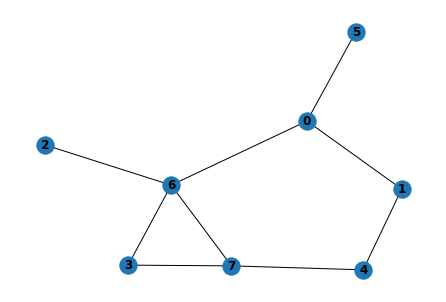

In [ ]:
edges = random_graph_generator(8, 10)
G = nx.Graph()
G.add_edges_from(list(edges))
nx.draw(G, with_labels=True, font_weight='bold')

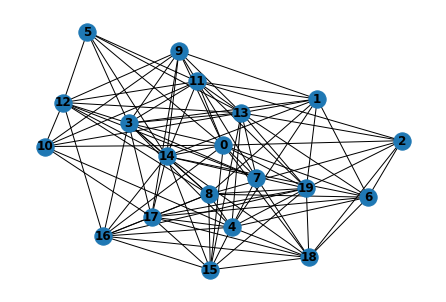

In [ ]:
edges = random_graph_generator(20, 150)
G = nx.Graph()
G.add_edges_from(list(edges))
nx.draw(G, with_labels=True, font_weight='bold')

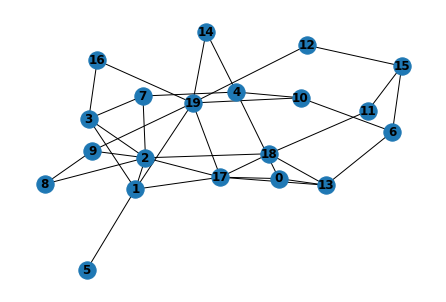

In [ ]:
edges = random_graph_generator(20, 40)
G = nx.Graph()
G.add_edges_from(list(edges))
nx.draw(G, with_labels=True, font_weight='bold')

In [ ]:
# GENERATING HUGE TEST DATA

batch_num = 0
for i in range(100, 301, 50):
    graphs_generated = 0
    batch_num += 1
    root_path = '/content/drive/MyDrive/ildazavr/test_dataset_random/batch' + str(batch_num) + '/'
    if not os.path.exists(root_path):
        os.makedirs(root_path)
    while graphs_generated < 10:
        edges = random_graph_generator(31, i)
        G = nx.Graph()
        G.add_edges_from(list(edges))
        if not nx.is_connected(G):
            continue
        coloring = coloring_of_graph(G)
        chromatic_number = max(coloring) + 1
        with open(root_path + 'file' + str(graphs_generated) + '.txt', 'w') as fp:
            fp.write(str(nx.to_numpy_matrix(G).tolist()))
            fp.write('\n' + str(chromatic_number))
            fp.write('\n' + str(coloring))
        graphs_generated += 1
    print("Cycle", i, "done!")

Cycle 100 done!
Cycle 150 done!
Cycle 200 done!


In [ ]:
# GENERATING TRAIN DATA
root_path = '/content/drive/MyDrive/ildazavr/train_random_dataset_exact_coloring/batch1/'
if not os.path.exists(root_path):
    os.makedirs(root_path)
graph_num = 0

for i in range(40, 71):
    graphs_generated = 0
    while graphs_generated < 7:
        edges = random_graph_generator(31, i)
        G = nx.Graph()
        G.add_edges_from(list(edges))
        if not nx.is_connected(G) or G.number_of_nodes() != 31:
            continue
        coloring = coloring_of_graph(G)
        chromatic_number = max(coloring) + 1
        with open(root_path + 'file' + str(graph_num) + '.txt', 'w') as fp:
            fp.write(str(nx.to_numpy_matrix(G).tolist()))
            fp.write('\n' + str(chromatic_number))
            fp.write('\n' + str(coloring))
        graphs_generated += 1
        graph_num += 1
    print("Cycle", i, "done!")

Cycle 40 done!
Cycle 41 done!
Cycle 42 done!
Cycle 43 done!
Cycle 44 done!
Cycle 45 done!
Cycle 46 done!
Cycle 47 done!
Cycle 48 done!
Cycle 49 done!
Cycle 50 done!
Cycle 51 done!
Cycle 52 done!
Cycle 53 done!
Cycle 54 done!
Cycle 55 done!
Cycle 56 done!
Cycle 57 done!
Cycle 58 done!
Cycle 59 done!
Cycle 60 done!
Cycle 61 done!
Cycle 62 done!
Cycle 63 done!
Cycle 64 done!
Cycle 65 done!
Cycle 66 done!
Cycle 67 done!
Cycle 68 done!
Cycle 69 done!
Cycle 70 done!


In [ ]:
# GENERATING TEST DATA
root_path = '/content/drive/MyDrive/ildazavr/test_random_dataset_exact_coloring/batch1/'
if not os.path.exists(root_path):
    os.makedirs(root_path)
graph_num = 0

for i in range(40, 71):
    graphs_generated = 0
    while graphs_generated < 3:
        edges = random_graph_generator(31, i)
        G = nx.Graph()
        G.add_edges_from(list(edges))
        if not nx.is_connected(G) or G.number_of_nodes() != 31:
            continue
        coloring = coloring_of_graph(G)
        chromatic_number = max(coloring) + 1
        with open(root_path + 'file' + str(graph_num) + '.txt', 'w') as fp:
            fp.write(str(nx.to_numpy_matrix(G).tolist()))
            fp.write('\n' + str(chromatic_number))
            fp.write('\n' + str(coloring))
        graphs_generated += 1
        graph_num += 1
    print("Cycle", i, "done!")

Cycle 40 done!
Cycle 41 done!
Cycle 42 done!
Cycle 43 done!
Cycle 44 done!
Cycle 45 done!
Cycle 46 done!
Cycle 47 done!
Cycle 48 done!
Cycle 49 done!
Cycle 50 done!
Cycle 51 done!
Cycle 52 done!
Cycle 53 done!
Cycle 54 done!
Cycle 55 done!
Cycle 56 done!
Cycle 57 done!
Cycle 58 done!
Cycle 59 done!
Cycle 60 done!
Cycle 61 done!
Cycle 62 done!
Cycle 63 done!
Cycle 64 done!
Cycle 65 done!
Cycle 66 done!
Cycle 67 done!
Cycle 68 done!
Cycle 69 done!
Cycle 70 done!
